# BERT for dummies
Tutorial: https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03


References:
* Attention-based learning:
BERT for Joint Intent Classification and Slot Filling: https://www.groundai.com/project/bert-for-joint-intent-classification-and-slot-filling/#bib.bib10

Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention): https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/

# Load ATIS (Airline Travel Information System) dataset

Tutorial to load and understand the ATIS dataset: https://towardsdatascience.com/natural-language-understanding-with-sequence-to-sequence-models-e87d41ad258b

Data source: https://www.kaggle.com/siddhadev/atis-dataset-from-ms-cntk?select=atis.train.pkl

In [44]:
import os
import pickle
import numpy as np  # linear algebra
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [45]:
DATA_DIR='./data/'

# load Pickle file
def load_ds(fname=os.path.join(DATA_DIR,'/atis.train.pkl'), verbose=True):
    with open(fname, 'rb') as strem:
        ds, dicts = pickle.load(strem)
    if verbose:
        print('Done  loading: ', fname)
        print('      samples: {:4d}'.format(len(ds['query'])))
        print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
        print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
        print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds, dicts
        
# convert Pickle file to array
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(DATA_DIR,filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

    if add_start_end_token:
        i2s[178] = 'BOS'
        i2s[179] = 'EOS'
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        if add_start_end_token:
            slot_text[0] = 'BOS'
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'
            slot_vector[-1]= 179
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
            print('Query text:', q)
            print('Query vector: ', query[i])
            print('Intent label: ', i2in[intent[i][0]])
            print('Slot text: ', slot)
            print('Slot vector: ', slot_vector)
            print('*'*74)
    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, query_data, intent_data, intent_data_label, slot_data

# load ATIS training dataset
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

# load ATIS testing dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
input_tensor_test, target_tensor_test, \
query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')
  

Done  loading:  ./data/atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS what 's the cheapest one way flight from oakland to boston EOS
Query vector:  [178 916   5 827 296 656 906 428 444 644 851 266 179]
Intent label:  flight
Slot text:  O O O O B-cost_relative B-round_trip I-round_trip O O B-fromloc.city_name O B-toloc.city_name O
Slot vector:  [128, 128, 128, 128, 21, 66, 119, 128, 128, 48, 128, 78, 128]
**************************************************************************
Query text: BOS how much is the ground transportation between atlanta and downtown EOS
Query vector:  [178 477 609 498 827 457 866 259 242 215 380 179]
Intent label:  ground_fare
Slot text:  O O O O O O O O B-fromloc.city_name O O O
Slot vector:  [128, 128, 128, 128, 128, 128, 128, 128, 48, 128, 128, 128]
**************************************************************************
Query text: BOS list all flights going from boston to atlanta on wednes

In [46]:
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame(
    {
        'query': query_data_train, 
        'intent': intent_data_label_train,
        'slot filling': slot_data_train
    })

In [47]:
df_small = pd.DataFrame(columns=['query', 'intent', 'slot filling'])

j = 0
for i in df.intent.unique():
    df_small.loc[j] = df[df.intent==i].iloc[0]
    j = j+1

df_small

,query,intent,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,14,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,19,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,3,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,1,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,21,O O O O O O O O B-city_name
5,what 's the airport at orlando,8,O O O O O B-city_name
6,which airline serves denver pittsburgh and atlanta,6,O O O B-fromloc.city_name B-fromloc.city_name O B-fromloc.city_name
7,how far is it from orlando airport to orlando,13,O O O O O B-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name
8,what is fare code h,0,O O O O B-fare_basis_code
9,how much does the limousine service cost within pittsburgh,20,O O O O B-transport_type O O O B-city_name


In [48]:
# 129 slot categories from the dataset
i2s_train_values = list(i2s_train.values())
df3 = pd.DataFrame()
for i in range(7):
    df3[str(i)] = i2s_train_values[i*15:(i+1)*15]
df3

,0,1,2,3,4,5,6
0,B-aircraft_code,B-arrive_time.time_relative,B-depart_date.year,B-flight_time,B-return_date.day_name,B-today_relative,I-arrive_time.time_relative
1,B-airline_code,B-booking_class,B-depart_time.end_time,B-fromloc.airport_code,B-return_date.day_number,B-toloc.airport_code,I-city_name
2,B-airline_name,B-city_name,B-depart_time.period_mod,B-fromloc.airport_name,B-return_date.month_name,B-toloc.airport_name,I-class_type
3,B-airport_code,B-class_type,B-depart_time.period_of_day,B-fromloc.city_name,B-return_date.today_relative,B-toloc.city_name,I-cost_relative
4,B-airport_name,B-compartment,B-depart_time.start_time,B-fromloc.state_code,B-return_time.period_mod,B-toloc.country_name,I-depart_date.day_name
5,B-arrive_date.date_relative,B-connect,B-depart_time.time,B-fromloc.state_name,B-return_time.period_of_day,B-toloc.state_code,I-depart_date.day_number
6,B-arrive_date.day_name,B-cost_relative,B-depart_time.time_relative,B-meal,B-round_trip,B-toloc.state_name,I-depart_date.today_relative
7,B-arrive_date.day_number,B-day_name,B-economy,B-meal_code,B-state_code,B-transport_type,I-depart_time.end_time
8,B-arrive_date.month_name,B-day_number,B-fare_amount,B-meal_description,B-state_name,I-airline_name,I-depart_time.period_of_day
9,B-arrive_date.today_relative,B-days_code,B-fare_basis_code,B-mod,B-stoploc.airport_code,I-airport_name,I-depart_time.start_time


# Creating Tensors

In [49]:
# creating tensors
def max_length(tensor):
    return max(len(t) for t in tensor)

# Helper function to pad the query tensor and slot (target) tensor to the same length. 
# Also creates a tensor for teacher forcing.
def create_tensors(input_tensor, target_tensor, nb_sample=9999999, max_len=0):
    len_input, len_target  = max_length(input_tensor), max_length(target_tensor)
    len_input = max(len_input,max_len)
    len_target = max(len_target,max_len)
    

    # Padding the input and output tensor to the maximum length
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=len_input,
                                                                 padding='post')

    teacher_data = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=len_target , 
                                                                  padding='post')
    
    target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
    target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
    target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))
    
    nb = len(input_data)
    p = np.random.permutation(nb)
    input_data = input_data[p]
    teacher_data = teacher_data[p]
    target_data = target_data[p]

    return (input_data[:min(nb_sample, nb)], teacher_data[:min(nb_sample, nb)], target_data[:min(nb_sample, nb)], 
           len_input, len_target)

In [50]:
input_data_train, teacher_data_train, target_data_train, len_input_train, len_target_train  = create_tensors(input_tensor_train, target_tensor_train)

input_data_test, teacher_data_test, target_data_test, len_input_test, len_target_test  = create_tensors(input_tensor_test, target_tensor_test, max_len=len_input_train)

In [51]:
def get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test):
    vocab_in_size = len({**t2i_train, **t2i_test})
    vocab_out_size = len({**s2i_train, **s2i_test})
    return vocab_in_size, vocab_out_size
  
vocab_in_size, vocab_out_size = get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test)
vocab_in_size, vocab_out_size

(943, 129)

In [52]:
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Dropout
# errro while importing CuDNNLSTM 
# from keras.layers import CuDNNLSTM
# according to user's comments on foruns, this happend because you can CuDNNLSTM is deprecated
# just import LSTM and use no activation function to get the same results
# https://forums.developer.nvidia.com/t/importerror-cannot-import-name-cudnnlstm-from-tensorflow-keras-layers/82778/2
from keras.layers import LSTM



# Building a Seq2Seq Model for Slot Filling

In [58]:

BUFFER_SIZE = len(input_data_train)
BATCH_SIZE = 124
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024

# Create the Encoder layers first.
encoder_inputs = Input(shape=(len_input_train,))
encoder_emb = Embedding(input_dim=vocab_in_size, output_dim=embedding_dim)
encoder_lstm = LSTM(units=units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_emb(encoder_inputs))
encoder_states = [state_h, state_c]

# Now create the Decoder layers.
decoder_inputs = Input(shape=(None,))
decoder_emb = Embedding(input_dim=vocab_out_size, output_dim=embedding_dim)
decoder_lstm = LSTM(units=units, return_sequences=True, return_state=True)
decoder_lstm_out, _, _ = decoder_lstm(decoder_emb(decoder_inputs), initial_state=encoder_states)
# Two dense layers to improve inference capabilities.
decoder_d1 = Dense(units, activation="relu")
decoder_d2 = Dense(vocab_out_size, activation="softmax")
# Drop-out is added in the dense layers to help mitigate overfitting in this part of the model.
decoder_out = decoder_d2(Dropout(rate=.4)(decoder_d1(Dropout(rate=.4)(decoder_lstm_out))))

# Finally, create a training model which combines the encoder and the decoder.
# Note that this model has three inputs:
#  encoder_inputs=[batch,encoded_words] from input (query)
#  decoder_inputs=[batch,encoded_words] from output (slots). This is the "teacher tensor".
#  decoder_out=[batch,encoded_words] from output (slots). This is the "target tensor".
model = Model([encoder_inputs, decoder_inputs], decoder_out)
# Use sparse_categorical_crossentropy so we don't have to expand decoder_out into a massive one-hot array.

# small changes from the original code
# import optimizers
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 48, 256)      241408      input_18[0][0]                   
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, None, 256)    33024       input_19[0][0]                   
______________________________________________________________________________________

# Training a Seq2Seq Model

In [59]:
epochs = 2
history = model.fit(
    [input_data_train, teacher_data_train],
    target_data_train,
    batch_size=BATCH_SIZE,
    epochs=epochs,
    validation_data=([input_data_test, teacher_data_test], target_data_test)
)

Epoch 1/2
41/41 [==============================] - 333s 8s/step - loss: 1.2876 - sparse_categorical_accuracy: 0.8025 - val_loss: 0.5296 - val_sparse_categorical_accuracy: 0.8767
Epoch 2/2
41/41 [==============================] - 344s 8s/step - loss: 0.5233 - sparse_categorical_accuracy: 0.8755 - val_loss: 0.4686 - val_sparse_categorical_accuracy: 0.8888


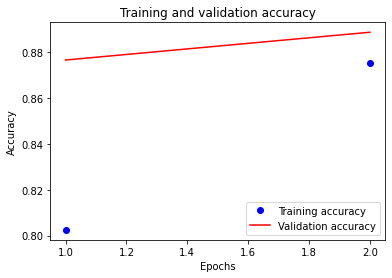

In [64]:
import matplotlib.pyplot as plt

def plot_training_accuracy(history):

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
  
plot_training_accuracy(history)

# Inference with a Seq2Seq Model

In [61]:
# Create the encoder model from the tensors we previously declared.
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Generate a new set of tensors for our new inference decoder. Note that we are using new tensors, 
# this does not preclude using the same underlying layers that we trained on. (e.g. weights/biases).
inf_decoder_inputs = Input(shape=(None,), name="inf_decoder_inputs")
# We'll need to force feed the two state variables into the decoder each step.
state_input_h = Input(shape=(units,), name="state_input_h")
state_input_c = Input(shape=(units,), name="state_input_c")
decoder_res, decoder_h, decoder_c = decoder_lstm(
    decoder_emb(inf_decoder_inputs), 
    initial_state=[state_input_h, state_input_c])
inf_decoder_out = decoder_d2(decoder_d1(decoder_res))
inf_model = Model(inputs=[inf_decoder_inputs, state_input_h, state_input_c], 
                  outputs=[inf_decoder_out, decoder_h, decoder_c])
                  
def preprocess_query(w):
    w = w.rstrip().strip().lower()
    w = "BOS " + w + " EOS"
    return w
  
# Converts the given query (just a string) into a vector of word IDs
# using the language specified. This can be used for either the input (query)
# or target (slot)
# Output is 1-D: [timesteps/words]
def query_to_vector(query, len_input=len_input_train, t2i=t2i_train):
    pre = preprocess_query(query)
    vec = np.zeros(len_input)
    query_list = [t2i[s] for s in pre.split(' ')]
    for i,w in enumerate(query_list):
        vec[i] = w
    return vec

# Given an input string, an encoder model (infenc_model) and a decoder model (infmodel),
# return a predicted slot string.
def predict_slots(input_query, infenc_model, infmodel, 
                  len_input=len_input_train, 
                  t2i=t2i_train, s2i=s2i_train, i2s=i2s_train,
                  len_target=len_target_train,
                  attention=False):
    sent_len = len(input_query.split())
    sv = query_to_vector(input_query, len_input, t2i)
    # Reshape so we can use the encoder model. New shape=[samples,sequence length]
    sv = sv.reshape(1,len(sv))
    [emb_out, sh, sc] = infenc_model.predict(x=sv)
    
    i = 0
    start_vec = s2i["O"]
    stop_vec = s2i["O"]
    # We will continuously feed cur_vec as an input into the decoder to produce the next word,
    # which will be assigned to cur_vec. Start it with "EOS".
    cur_vec = np.zeros((1,1))
    cur_vec[0,0] = start_vec
    cur_word = "BOS"
    output_query = ""
    # Start doing the feeding. Terminate when the model predicts an "EOS" or we reach the end
    # of the max target slot length.
    while cur_word != "EOS" and i < (len_target-1) and i < sent_len+1:
        i += 1
        if cur_word != "BOS":
            output_query = output_query + " " + cur_word
        x_in = [cur_vec, sh, sc]
        # This will allow us to accomodate attention models, which we will talk about later.
        if attention:
            x_in += [emb_out]
        [nvec, sh, sc] = infmodel.predict(x=x_in)
        # The output of the model is a massive softmax vector with one spot for every possible word. Convert
        # it to a word ID using argmax().
        cur_vec[0,0] = np.argmax(nvec[0,0])
        cur_word = i2s[np.argmax(nvec[0,0])]
    return output_query
    
input_query = "what is the cheapest flight from boston to san francisco"
print(predict_slots(input_query, encoder_model, inf_model))

 O O O O O O O O O O
